In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

In [2]:
import os
import re

In [3]:
random_seed = 42
early_stopping_round = 100

In [16]:
def perform_eda(X, y):
        """Perform Exploratory Data Analysis"""
        # Feature distributions
        shape_col_f = 3
        shape_row_f = X.shape[1] // shape_col_f + int(X.shape[1] % shape_col_f != 0)

        shape_col_t = 2        
        shape_row_t = y.shape[1] // shape_col_t + int(y.shape[1] % shape_col_t != 0) 
        
        fig, axes = plt.subplots(shape_row_f, shape_col_f, figsize=(15 * shape_row_f/shape_col_f, 15))
        for idx, col in enumerate(X.columns):
            row = idx // shape_col_f
            col_idx = idx % shape_row_f
            sns.histplot(X[col], ax=axes[row, col_idx], bins = 50)
            axes[row, col_idx].set_title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()
        
        # Correlation matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
        plt.title('Feature Correlation Matrix')
        plt.show()
        
        # Target variable distributions
        fig, axes = plt.subplots(shape_row_t, shape_col_t, figsize=(12 * shape_row_t/shape_col_t, 8))
        for idx, col in enumerate(y.columns):
            row = idx // shape_col_t
            col_idx = idx % shape_row_t
            sns.histplot(y[col], ax=axes[row, col_idx], bins = 50)
            axes[row, col_idx].set_title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()
        
        # Feature-target correlations
        plt.figure(figsize=(12, 8))
        correlations = pd.concat([X, y], axis=1).corr().iloc[:X.shape[1], X.shape[1]:]
        sns.heatmap(correlations, annot=True, cmap='coolwarm')
        plt.title('Feature-Target Correlations')
        plt.show()

In [5]:
def performance_visualizations(y_pred, y_test):
    metrics = {'mse': {}, 'r2': {}, 'rmse': {}}
    
    for target in y_test.columns:
        y_true = y_test[target]
        metrics['mse'][target] = [mean_squared_error(y_true, y_pred[target])]
        metrics['r2'][target] = [r2_score(y_true, y_pred[target])]
        metrics['rmse'][target] = [root_mean_squared_error(y_true, y_pred[target])]
        
    # Plot MSE comparison
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    mse_df = pd.DataFrame.from_dict(metrics['mse']).melt()
    sns.barplot(x='variable', y='value', data=mse_df)
    plt.title('Mean Squared Error by Model and Target')
    plt.xticks(rotation=45)
    
    # Plot R² comparison
    plt.subplot(1, 3, 2)
    r2_df = pd.DataFrame(metrics['r2']).melt()
    sns.barplot(x='variable', y='value', data=r2_df)
    plt.title('R² Score by Model and Target')
    plt.xticks(rotation=45)

    # Plot RMSE comparison
    plt.subplot(1, 3, 3)
    rmse_df = pd.DataFrame(metrics['rmse']).melt()
    sns.barplot(x='variable', y='value', data=rmse_df)
    plt.title('RMSE Score by Model and Target')
    plt.xticks(rotation=45)
    plt.show()
    
    
    # Actual vs Predicted plots
    shape_col = 2
    shape_row = y_test.shape[1] // shape_col + int(y_test.shape[1] % shape_col != 0) 
    
    fig, axes = plt.subplots(shape_row, shape_col, figsize=(10, 10))
    fig.suptitle(f'Actual vs Predicted')
    for idx, target in enumerate(y_test.columns):
        row = idx // shape_row
        col = idx % shape_col
        
        axes[row, col].scatter(y_test[target], y_pred[target], alpha=0.5)
        axes[row, col].plot([y_test[target].min(), y_test[target].max()],
                                [y_test[target].min(), y_test[target].max()], 'r--', lw=2)
        axes[row, col].set_title(f'{target}')
        axes[row, col].set_xlabel('Actual')
        axes[row, col].set_ylabel('Predicted')            
    plt.tight_layout()
    plt.show()
    
    metrics_df = pd.DataFrame.from_dict(metrics)
    metrics_df = metrics_df.map(lambda x: x[0] if isinstance(x, list) else x)
    metrics_df = metrics_df.astype(float)
    print(metrics_df)

In [40]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [41]:
filename_features = "features.csv"
filename_target = "target-7_8125.csv"

In [44]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    if X_tmp.columns[0] != "y":
        col_y = np.ones(X_tmp.shape[0]) * 1000
        X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(1872, 8) (1872, 4)
(1100, 8) (1100, 4)
(10780, 8) (10780, 4)


((13752, 8), (13752, 4))

## EDA

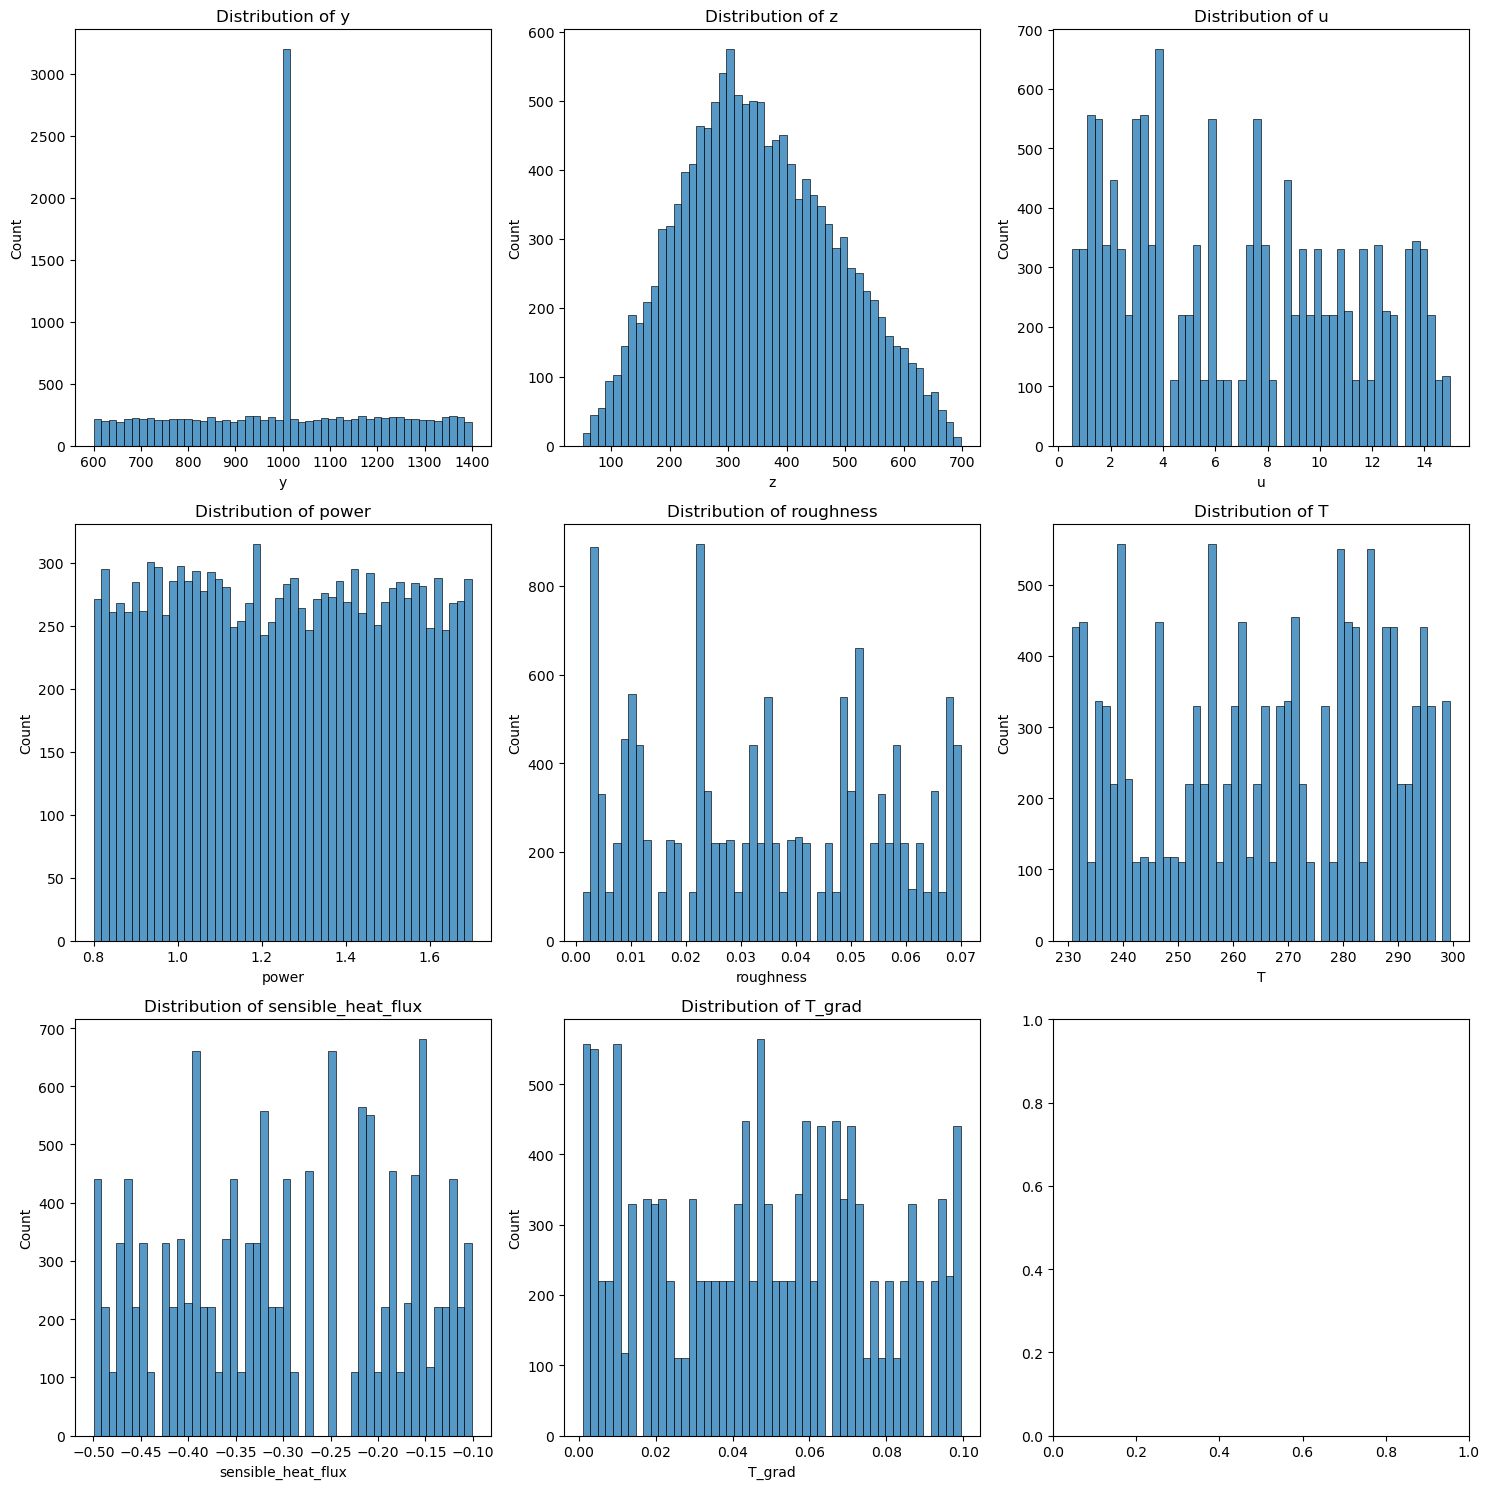

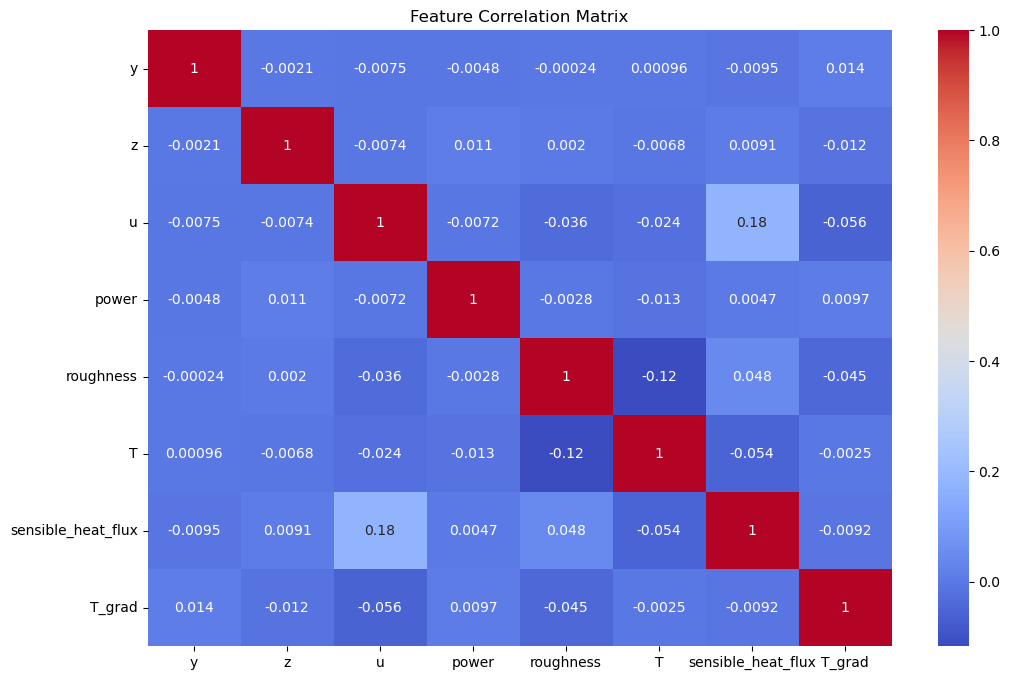

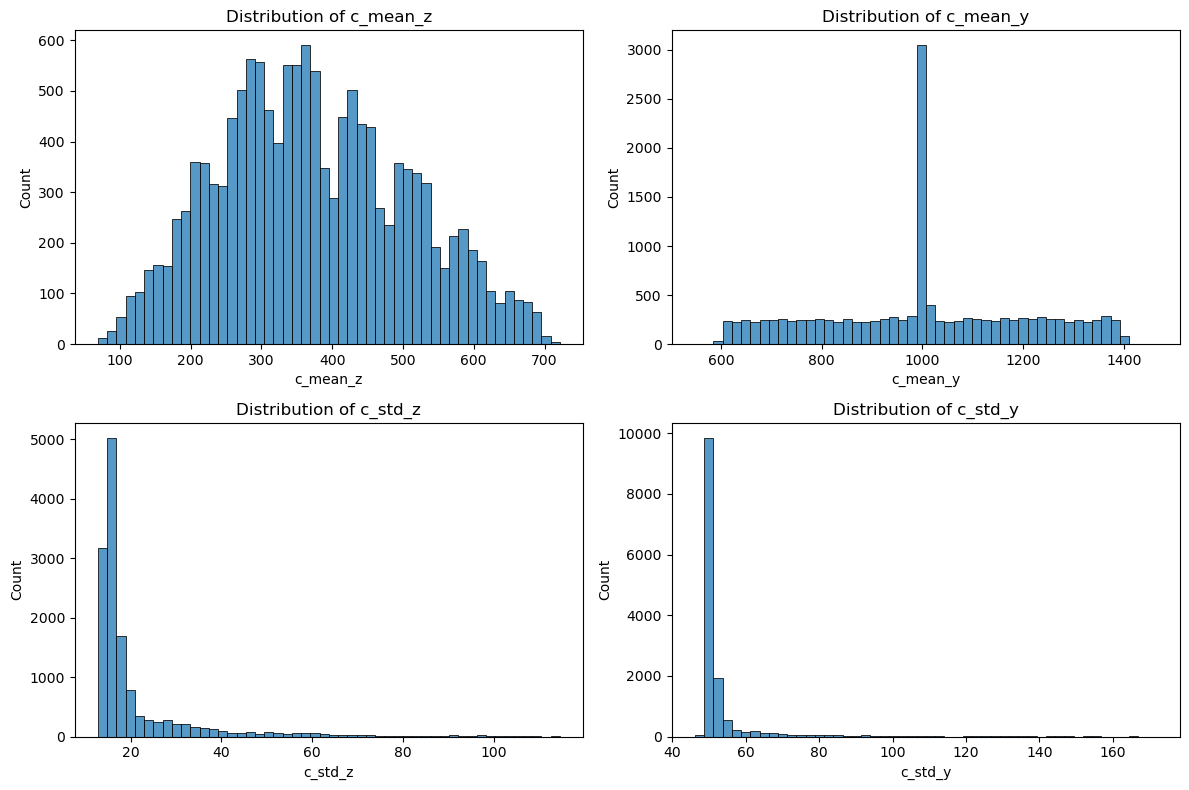

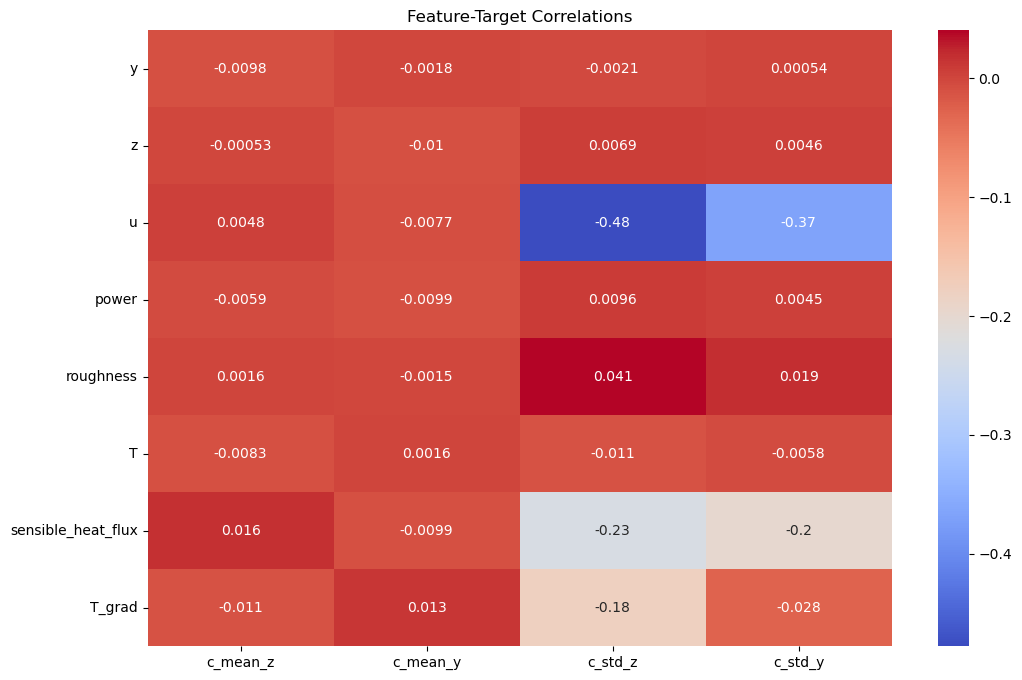

In [45]:
perform_eda(X, y)

## Test-train split

In [11]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [46]:
# for small dataset
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [47]:
# for small dataset
X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((9900, 8), (9900, 4), (1101, 8), (1101, 4))

In [14]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((596090, 9), (596090, 4), (165581, 9), (165581, 4), (66233, 9), (66233, 4))

## Models

### Constant model

In [48]:
y_pred = {}
for target in y_train.columns:
    y_pred[target] = np.mean(y_train[target]) * np.ones(len(y_test[target]))

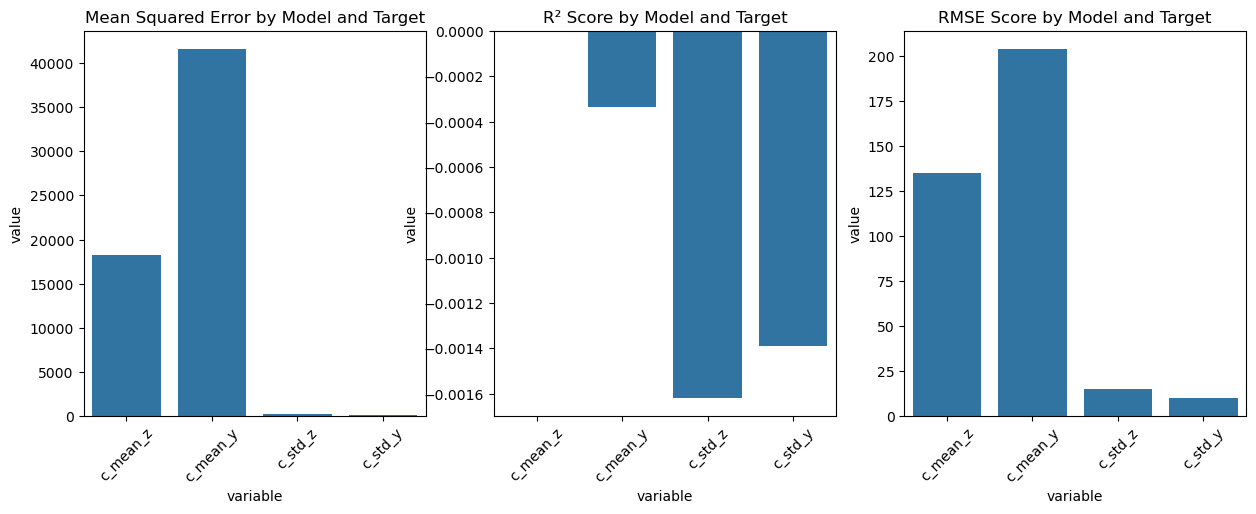

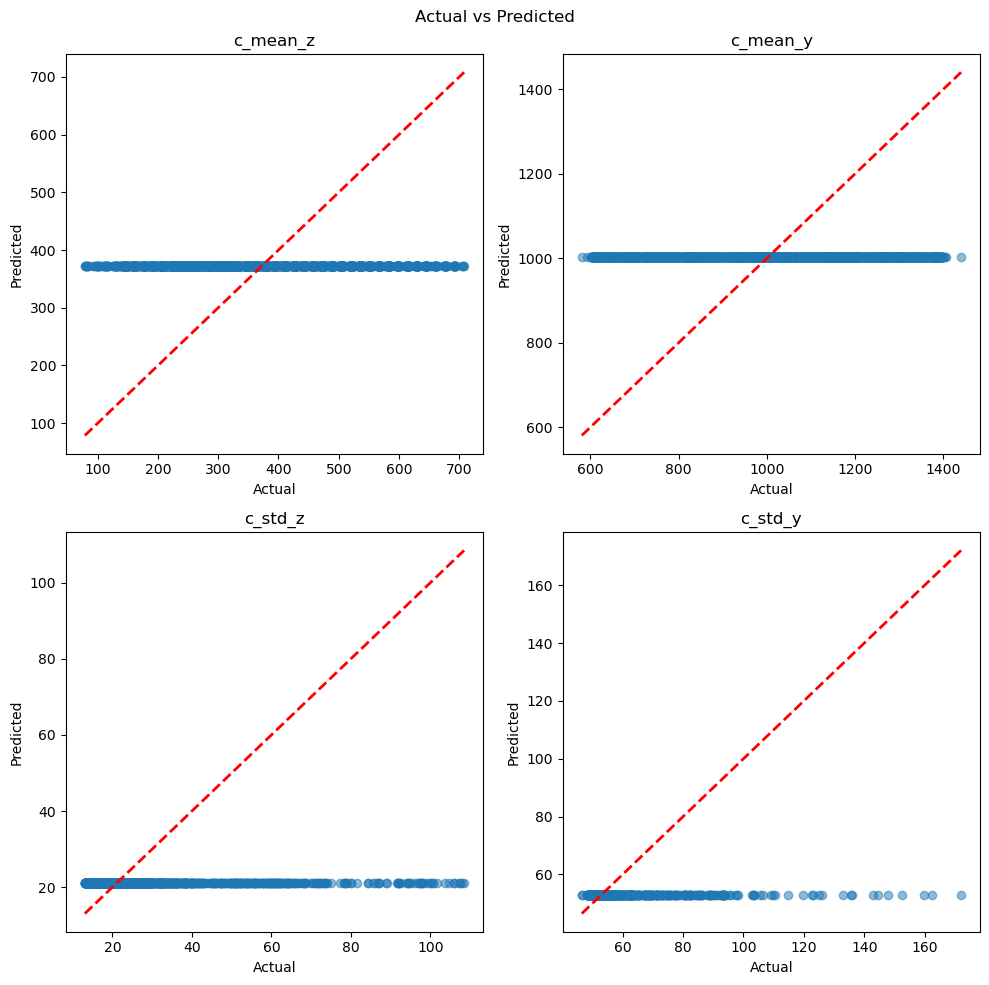

                   mse        r2        rmse
c_mean_z  18189.403996 -0.000003  134.868099
c_mean_y  41588.448847 -0.000335  203.932461
c_std_z     215.977415 -0.001617   14.696170
c_std_y     100.200285 -0.001392   10.010009


In [49]:
performance_visualizations(y_pred, y_test)

### Random model

In [50]:
y_pred = {}
for target in y_train.columns:
    y_pred[target] = np.random.normal(np.min(y_train[target]), np.max(y_train[target]), len(y_test))

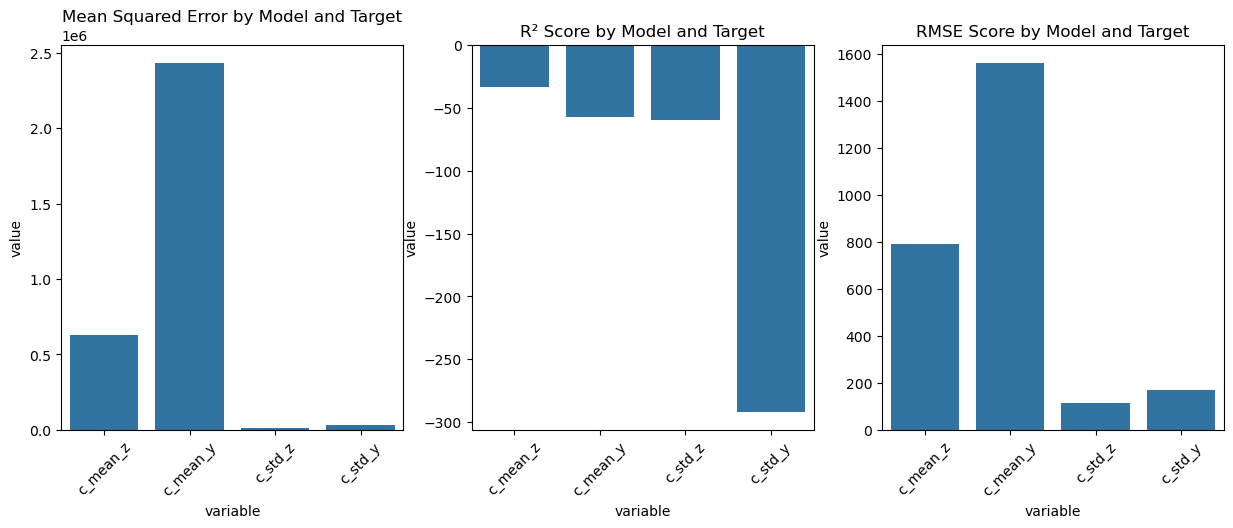

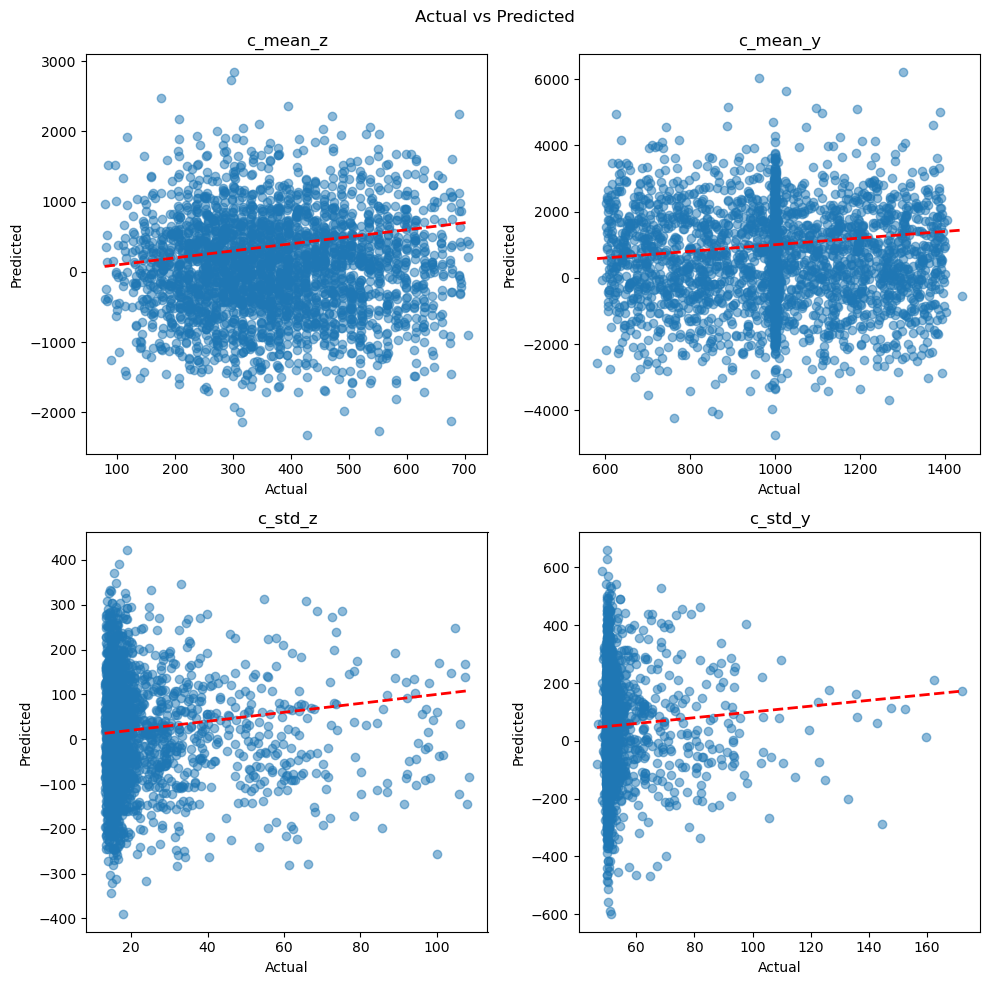

                   mse          r2         rmse
c_mean_z  6.264649e+05  -33.441309   791.495340
c_mean_y  2.430873e+06  -57.470230  1559.125658
c_std_z   1.307899e+04  -59.655154   114.363410
c_std_y   2.926869e+04 -291.508388   171.080933


In [51]:
performance_visualizations(y_pred, y_test)

## Catboost with optuna

In [17]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        # 'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [18]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
study.optimize(objective, n_trials=1000, n_jobs=-1, timeout=7200)

[I 2025-01-17 14:07:53,598] A new study created in memory with name: catboost-seed42
[I 2025-01-17 14:11:42,445] Trial 27 finished with value: 115.82278668119095 and parameters: {'learning_rate': 0.0072449367945722565, 'depth': 1, 'l2_leaf_reg': 0.17538050093607016, 'min_child_samples': 4}. Best is trial 27 with value: 115.82278668119095.
[I 2025-01-17 14:11:43,887] Trial 102 finished with value: 115.35968985670073 and parameters: {'learning_rate': 0.008418325600945176, 'depth': 1, 'l2_leaf_reg': 0.9796032708466685, 'min_child_samples': 16}. Best is trial 102 with value: 115.35968985670073.
[I 2025-01-17 14:11:44,142] Trial 32 finished with value: 113.93755764822055 and parameters: {'learning_rate': 0.013391674963210868, 'depth': 1, 'l2_leaf_reg': 0.5569083079174992, 'min_child_samples': 32}. Best is trial 32 with value: 113.93755764822055.
[I 2025-01-17 14:11:47,058] Trial 47 finished with value: 113.00861649247824 and parameters: {'learning_rate': 0.0191634852371551, 'depth': 1, 'l2_

RuntimeError: Attempt to pop from an empty stack

In [19]:
print(study.best_value)
print(study.best_params)

100.47450952063343
{'learning_rate': 0.012222773725010277, 'depth': 9, 'l2_leaf_reg': 2.48001112979733, 'min_child_samples': 8}


In [52]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [53]:
%%time
y_pred ={}
for target in y_train.columns:
    
    optimized_regressor = CatBoostRegressor(learning_rate=best_params['learning_rate'],
                                            depth=best_params['depth'],
                                            l2_leaf_reg=best_params['l2_leaf_reg'],
                                            min_child_samples=best_params['min_child_samples'],
                                            grow_policy='Depthwise',
                                            iterations=1000,
                                            use_best_model=True,
                                            eval_metric='RMSE',
                                            loss_function= 'RMSE',
                                            thread_count = -1,
                                            od_type='iter',
                                            od_wait=20,
                                            random_state=random_seed,
                                            logging_level='Silent')
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp 

CPU times: user 31min 41s, sys: 4min 13s, total: 35min 55s
Wall time: 19.4 s


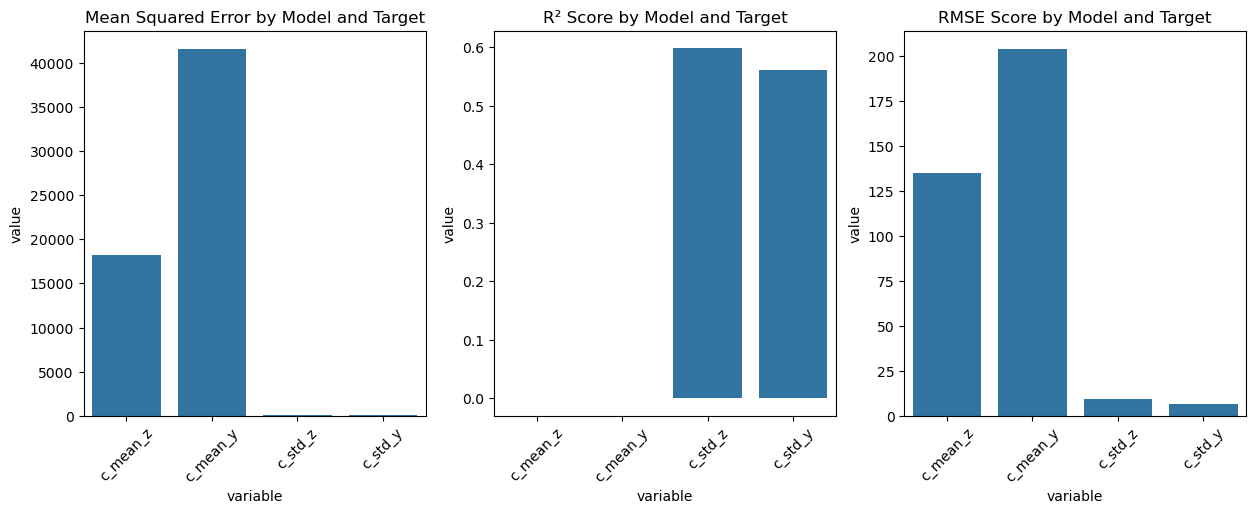

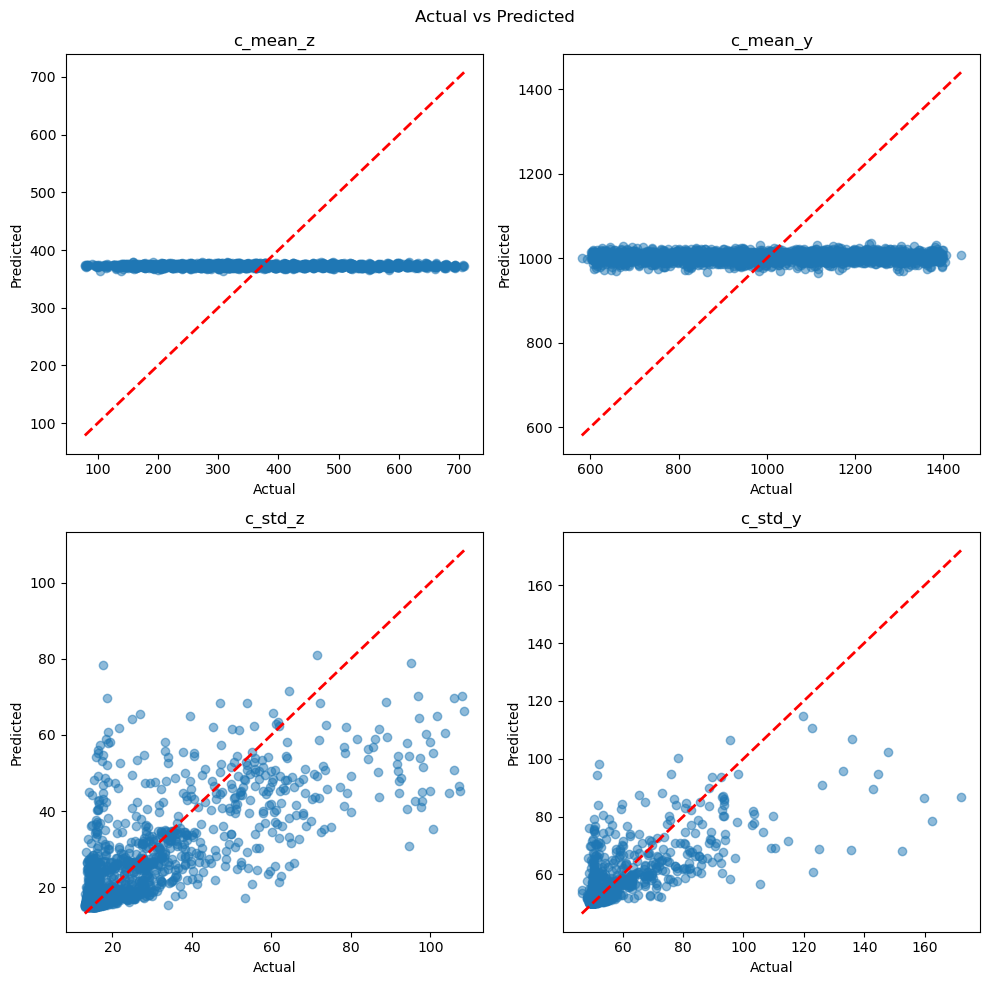

                   mse        r2        rmse
c_mean_z  18191.158548 -0.000100  134.874603
c_mean_y  41527.237641  0.001138  203.782329
c_std_z      86.712759  0.597861    9.311969
c_std_y      43.895451  0.561313    6.625364


In [54]:
performance_visualizations(y_pred, y_test)